In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-10-26 01:49:40.162916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 01:49:40.285296: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 01:49:40.802409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tharci/anaconda3/lib/
2022-10-26 01:49:40.803240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: c

In [2]:
from __future__ import print_function
from tensorflow import keras
import numpy as np
import cv2

import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
seed = 123
zoom = 2
downscale_fact = 2

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 200
image_width = 200

images_path = '../images'
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=zoom_range,
    horizontal_flip=True,
    validation_split=0.2,
    # featurewise_center=True
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='training'
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='validation'
)


def preprocess_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], image_height, image_width, 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = preprocess_img(batch[i])
        yield batch_crops, batch_crops

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)



Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


In [4]:
print(train_ds_prep)
print(np.max(next(train_ds_prep)[0]))
print('asd', next(train_ds_prep)[0].shape)
print('asd', next(train_ds_prep)[1].shape)
train_ds.reset()

<generator object preprocess_generator at 0x7f18345780b0>
1.0
asd (32, 200, 200, 3)
asd (32, 200, 200, 3)


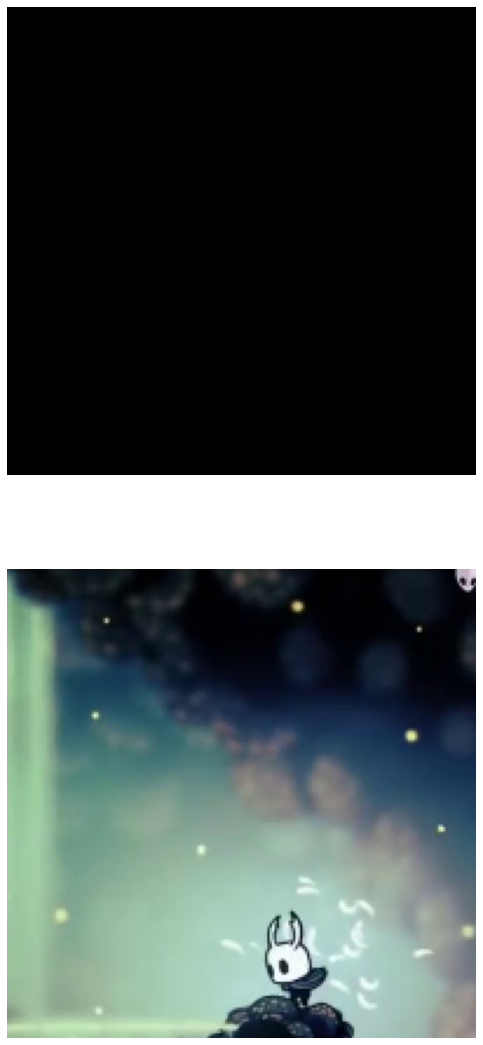

In [5]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [90]:
import tensorflow
from keras import mixed_precision
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, Dropout, BatchNormalization, Conv2DTranspose
from keras.layers import UpSampling2D, concatenate
from keras.models import Model, Sequential
from keras.activations import softmax
from keras.regularizers import l2


def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))

def create_improved_baseline_model_12x_comp(image_width, image_height):
    ### Encoder ###

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_width, image_height, 3)))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))


    ### Decoder ###

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='valid', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))
    #
    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model


def my_conv(x, filters, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer='he_normal', name=None):
  x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name=name)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def my_convTrans(x, filters, kernel_size=3, strides=(2, 2), padding='same', kernel_initializer='he_normal', name=None):
  x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name=name)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x


In [91]:
def split_autoencoder(autoencoder):
    # Get encoder
    encoder = Model(inputs=autoencoder.layers[0].input, outputs=autoencoder.get_layer('encoded').output)
    decoder_input = Input(shape=(12, 12, 32))
    decoder = Model(inputs=autoencoder.get_layer('decoder_input').input, outputs=autoencoder.layers[-1].output)

    return encoder, decoder

In [92]:
autoencoder = create_improved_baseline_model_12x_comp(image_width, image_height)
#autoencoder = create_unet(image_width, image_height)
# encoder, decoder = split_autoencoder(autoencoder)
autoencoder.summary()

('shape of encoded', (None, 12, 12, 32))
('shape of decoded', (None, 200, 200, 3))
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 100, 100, 16)      2368      
                                                                 
 batch_normalization_148 (Ba  (None, 100, 100, 16)     64        
 tchNormalization)                                               
                                                                 
 activation_149 (Activation)  (None, 100, 100, 16)     0         
                                                                 
 conv2d_90 (Conv2D)          (None, 100, 100, 16)      2320      
                                                                 
 batch_normalization_149 (Ba  (None, 100, 100, 16)     64        
 tchNormalization)                                               
                                    

In [93]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0025), loss=ssim_loss)
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss='binary_crossentropy')
# autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.05), loss=ssim_loss)

In [94]:

autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=55,
                verbose=1)


Epoch 1/55
106/106 [==============================] - 63s 570ms/step - loss: 0.2391 - val_loss: 0.2586
Epoch 2/55
106/106 [==============================] - 61s 580ms/step - loss: 0.1002 - val_loss: 0.0973
Epoch 3/55
106/106 [==============================] - 61s 584ms/step - loss: 0.0871 - val_loss: 0.0930
Epoch 4/55
106/106 [==============================] - 56s 528ms/step - loss: 0.0792 - val_loss: 0.0816
Epoch 5/55
106/106 [==============================] - 55s 526ms/step - loss: 0.0740 - val_loss: 0.0839
Epoch 6/55
106/106 [==============================] - 58s 550ms/step - loss: 0.0716 - val_loss: 0.0745
Epoch 7/55
106/106 [==============================] - 64s 607ms/step - loss: 0.0692 - val_loss: 0.0692
Epoch 8/55
 42/106 [==========>...................] - ETA: 26s - loss: 0.0674

KeyboardInterrupt: 

In [ ]:
# Saving the model:
# autoencoder.save('../model-saves/improved-12x-RGB-v2/')

In [13]:
# Loading the model
# autoencoder = keras.models.load_model('../model-saves/improved-12x-RGB-v2/', custom_objects={
#     'ssim_loss': ssim_loss
# })

# autoencoder.summary()

1/1 [==============================] - 0s 450ms/step


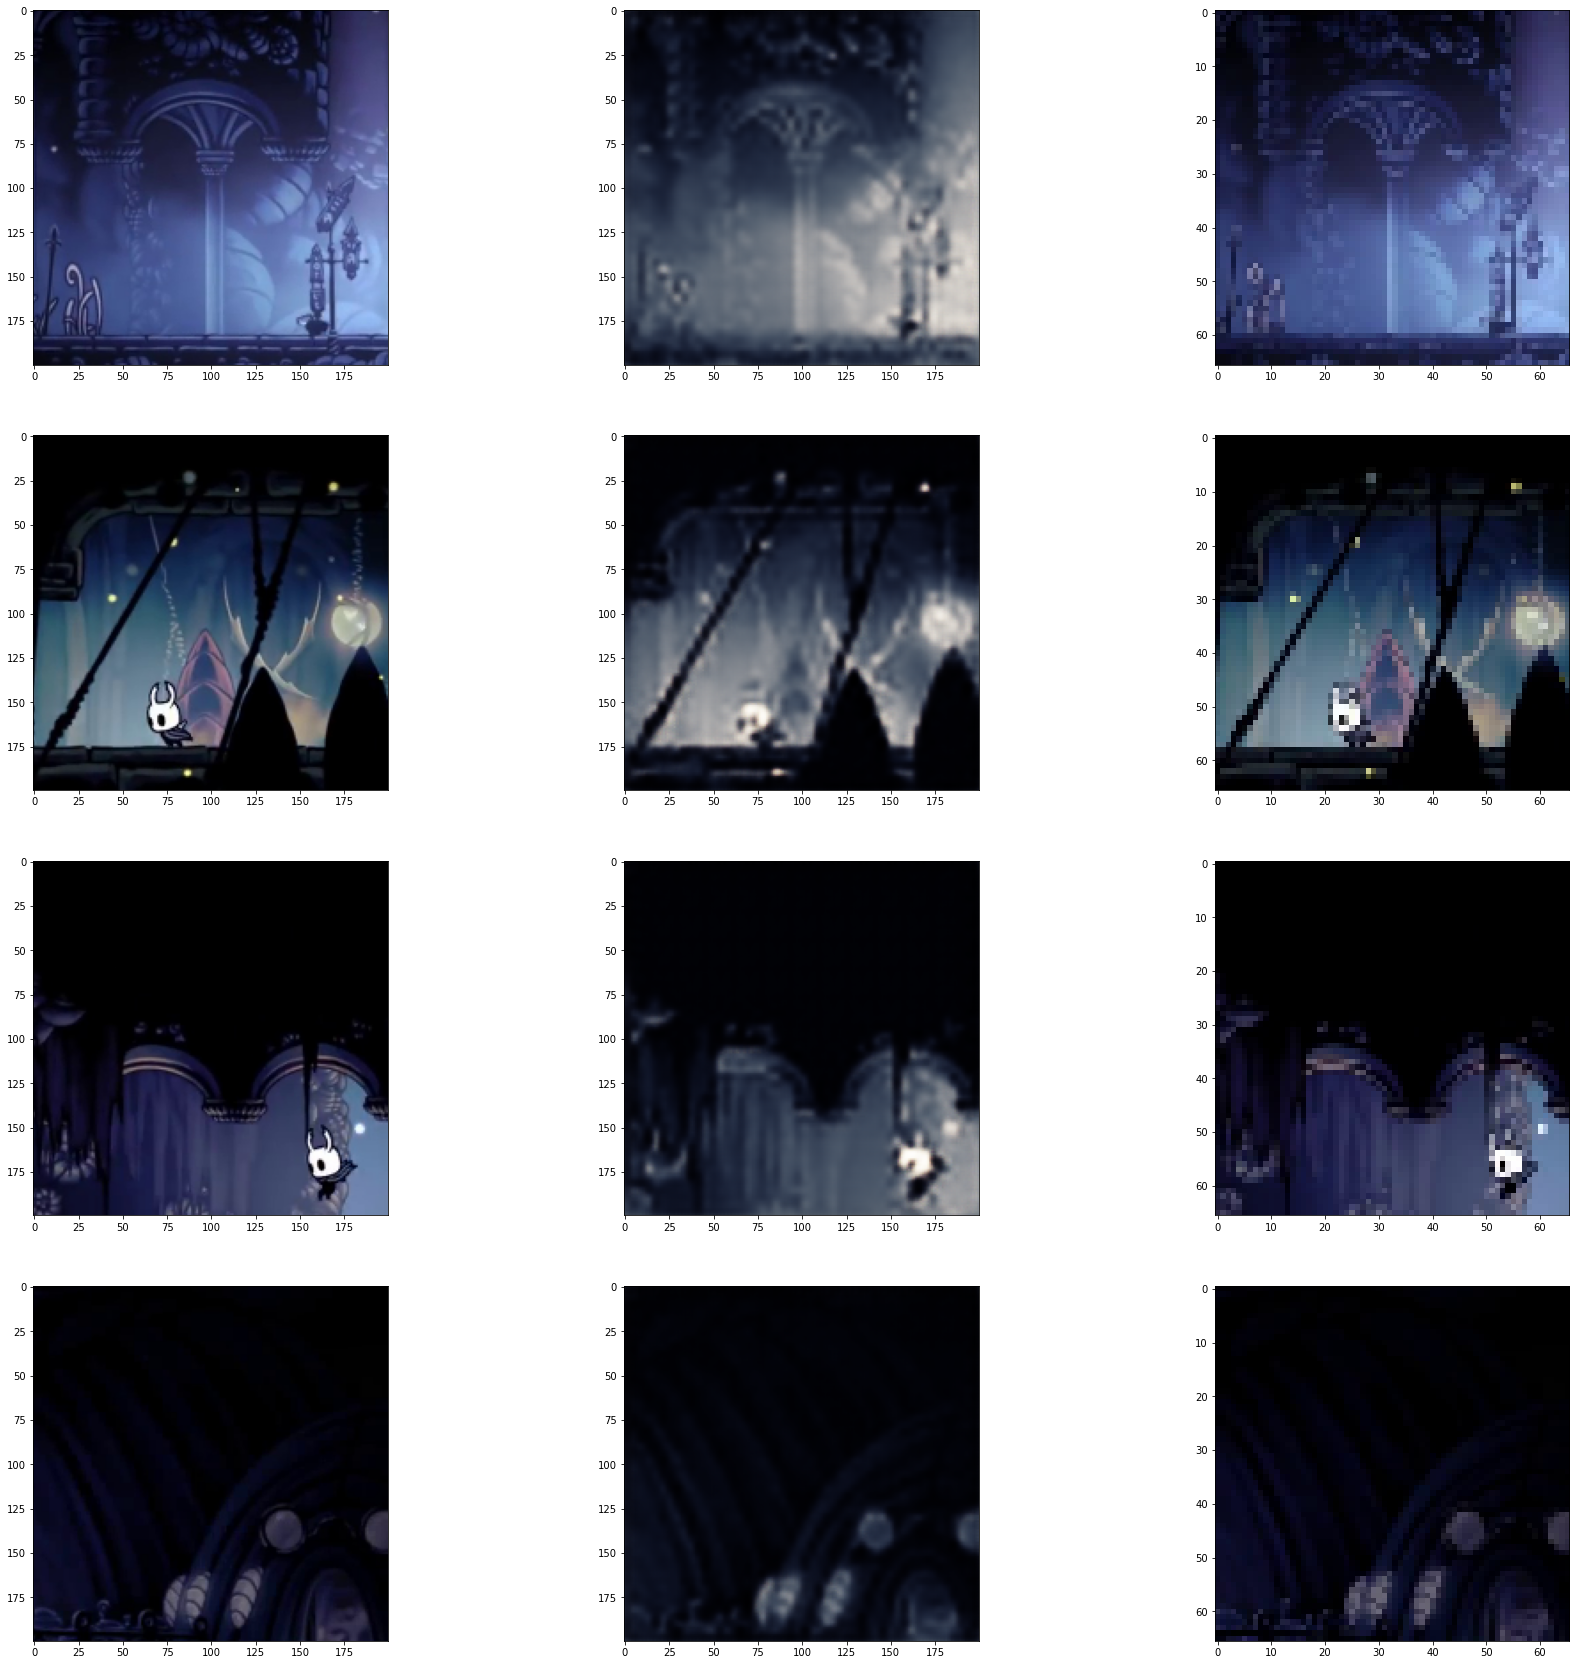

In [95]:
from matplotlib.pyplot import axes
import numpy as np

img_number = 4
test_images = next(test_ds_prep)[0][:img_number]
decoded_imgs = autoencoder.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(in_img, (in_img.shape[0] // 3, in_img.shape[1] // 3))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')